# RIG SCHEDULING SYSTEM OPTIMIZATION USING GENETIC ALGORITHM (GA) IN THE OIL & GAS INDUSTRY

**Objective:**
Optimize rig scheduling to achieve high execution rate and BOPD rate.

**Input:**


* List of wells: Well[i] = {id, production_value, x, y}
* Production value (BOPD)
* Distance between wells: calculated using Euclidean distance / Haversine formula
* Job duration (including moving time)

**Output:**
Optimal visiting schedule (well sequence) with comparison:
* Conventional vs. GA-1 (non-tier)
* Conventional vs. GA-2 (tier)

Created by ADW

# IMPORT LIBRARY

In [1]:
!pip install adjustText
!pip install folium
!pip install pillow


In [9]:
# RIG SCHEDULING OPTIMIZATION WITH GENETIC ALGORITHM
# Objective: Optimize rig scheduling using GA considering distance/time and BOPD

# LIBRARY
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from matplotlib.collections import LineCollection
from adjustText import adjust_text
from datetime import timedelta, datetime
from sklearn.preprocessing import MinMaxScaler
from itertools import permutations

# DATA PREPARATION




In [12]:
df = pd.read_csv("sample_wells.csv")
df.head()

print("Available Columns:", df.columns)
print("Number of rows:", df.shape)
print("Missing value per columns:\n", df.isnull().sum())
print("Number of duplicat rows:", df.duplicated().sum())

Available Columns: Index(['WELL_ALIAS', 'SURFACE_LATITUDE', 'SURFACE_LONGITUDE', 'BOPD',
       'START_DATETIME_JOB', 'END_DATETIME_JOB', 'MOVING_TIME'],
      dtype='object')
Number of rows: (146, 7)
Missing value per columns:
 WELL_ALIAS            0
SURFACE_LATITUDE      0
SURFACE_LONGITUDE     0
BOPD                  0
START_DATETIME_JOB    0
END_DATETIME_JOB      0
MOVING_TIME           0
dtype: int64
Number of duplicat rows: 0


In [14]:
# Convert DATE to datetime format
df['START_DATETIME_JOB'] = pd.to_datetime(df['START_DATETIME_JOB'])
df['END_DATETIME_JOB'] = pd.to_datetime(df['END_DATETIME_JOB'])
df['Month'] = df['START_DATETIME_JOB'].dt.to_period('M')  # Periode bulanan
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146 entries, 0 to 145
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   WELL_ALIAS          146 non-null    object        
 1   SURFACE_LATITUDE    146 non-null    float64       
 2   SURFACE_LONGITUDE   146 non-null    float64       
 3   BOPD                146 non-null    float64       
 4   START_DATETIME_JOB  146 non-null    datetime64[ns]
 5   END_DATETIME_JOB    146 non-null    datetime64[ns]
 6   MOVING_TIME         146 non-null    float64       
 7   Month               146 non-null    period[M]     
dtypes: datetime64[ns](2), float64(4), object(1), period[M](1)
memory usage: 9.3+ KB


In [ ]:
df.isnull().sum()

,0
NO,0
WELL_ALIAS,0
BOPD,0
SURFACE_LATITUDE,0
SURFACE_LONGITUDE,0
TOP_X,0
TOP_Y,0
RIG_ALIAS,0
REQ_DT,0
START_DATE_JOB,0


In [15]:
# EDA

df.describe()

,SURFACE_LATITUDE,SURFACE_LONGITUDE,BOPD,START_DATETIME_JOB,END_DATETIME_JOB,MOVING_TIME
count,146.000000,146.000000,146.000000,146,146,146.000000
mean,2.499999,117.000000,45.759589,2023-12-26 13:50:57.534246656,2023-12-31 08:22:23.835616512,0.759863
min,2.432991,116.880729,3.000000,2023-01-03 19:00:00,2023-01-15 22:00:00,0.340000
25%,2.480575,116.969246,24.250000,2023-06-28 04:30:00,2023-06-30 07:30:00,0.510000
50%,2.503986,116.983456,36.000000,2023-12-10 20:15:00,2023-12-12 16:45:00,0.510000
75%,2.521848,117.030591,61.500000,2024-07-03 01:22:30,2024-07-05 10:45:00,1.030000
max,2.565097,117.116184,213.000000,2024-12-24 16:30:00,2025-01-02 21:30:00,2.750000
std,0.026635,0.048417,35.447618,NaN,NaN,0.411939


In [17]:
# Print the first and last start dates
first_start = df['START_DATETIME_JOB'].min()
last_start = df['START_DATETIME_JOB'].max()

print(f"First start date: {first_start}")
print(f"Last start date: {last_start}")

assert all(df['END_DATETIME_JOB'] >= df['START_DATETIME_JOB']) # There is a job with end date earlier than start date

# Display the route order horizontally
print(" → ".join(df['WELL_ALIAS'].tolist()))


First start date: 2023-01-03 19:00:00
Last start date: 2024-12-24 16:30:00
WELL-1670 → WELL-804 → WELL-808 → WELL-833 → WELL-825 → WELL-1750 → WELL-991 → WELL-657 → WELL-774 → WELL-778 → WELL-1448 → WELL-1493 → WELL-1136 → WELL-1562 → WELL-879 → WELL-621 → WELL-1669 → WELL-861 → WELL-732 → WELL-548 → WELL-1263 → WELL-1127 → WELL-1607 → WELL-1452 → WELL-1686 → WELL-1330 → WELL-1361 → WELL-984 → WELL-652 → WELL-657 → WELL-1677 → WELL-1098 → WELL-1016 → WELL-1230 → WELL-1698 → WELL-1564 → WELL-785 → WELL-1646 → WELL-1540 → WELL-693 → WELL-1360 → WELL-1307 → WELL-932 → WELL-1671 → WELL-784 → WELL-572 → WELL-1666 → WELL-1697 → WELL-1668 → WELL-789 → WELL-769 → WELL-1708 → WELL-820 → WELL-1260 → WELL-1129 → WELL-1712 → WELL-1496 → WELL-1650 → WELL-896 → WELL-1351 → WELL-1506 → WELL-1401 → WELL-597 → WELL-1363 → WELL-1304 → WELL-1092 → WELL-1719 → WELL-1317 → WELL-533 → WELL-1058 → WELL-1607 → WELL-862 → WELL-1623 → WELL-825 → WELL-797 → WELL-844 → WELL-1692 → WELL-892 → WELL-1268 → WELL-976 

/tmp/ipython-input-1436646323.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(years))


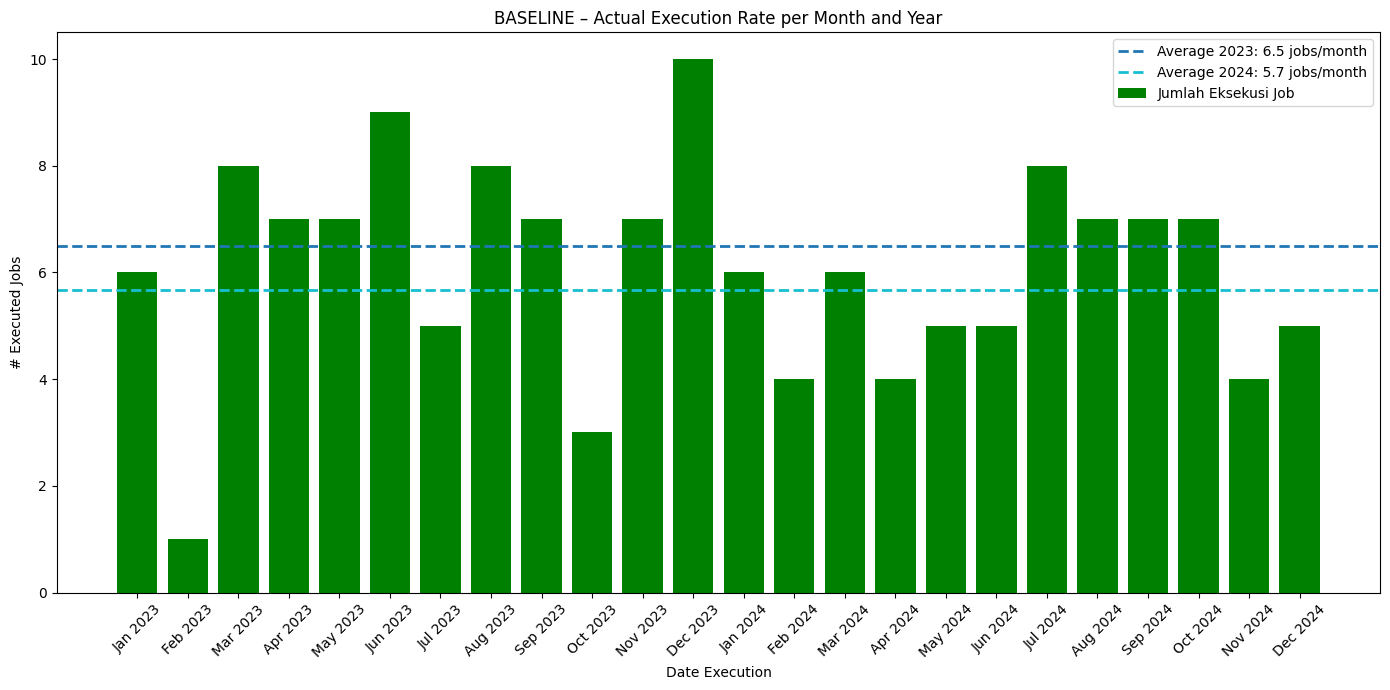

In [23]:
# Drop the column if it already exists
for col in ['Month_Label', 'Month_Sort', 'Year']:
    if col in df.columns:
        df.drop(columns=[col], inplace=True)

# Create new columns
df['Month_Label'] = df['START_DATETIME_JOB'].dt.strftime('%b %Y')
df['Month_Sort'] = df['START_DATETIME_JOB'].dt.to_period('M').astype(str)
df['Year'] = df['START_DATETIME_JOB'].dt.year

# Group data by month
month_counts = df.groupby(['Year', 'Month_Sort', 'Month_Label']).size().reset_index(name='Jumlah')
month_counts = month_counts.sort_values(by=['Month_Sort'])

# Create a list of unique months as the X-axis (sorted by time)
all_months = sorted(month_counts['Month_Sort'].unique())
month_labels = month_counts.drop_duplicates('Month_Sort').set_index('Month_Sort').loc[all_months]['Month_Label'].tolist()

plt.figure(figsize=(14,7))

# Plot a bar for each month (total number of jobs across all years)
# If data from different years but the same month should be summed, regroup here:
total_per_month = month_counts.groupby('Month_Sort')['Jumlah'].sum().reindex(all_months).fillna(0)
plt.bar(range(len(all_months)), total_per_month, color='green', label='Jumlah Eksekusi Job')

# Plot the yearly average line (dotted line)
years = month_counts['Year'].unique()
colors = plt.cm.get_cmap('tab10', len(years))

for i, year in enumerate(years):
    data_year = month_counts[month_counts['Year'] == year]
    avg_jumlah = data_year['Jumlah'].mean()
    plt.axhline(y=avg_jumlah, color=colors(i), linestyle='--', linewidth=2, label=f'Average {year}: {avg_jumlah:.1f} jobs/month')

# Set labels dan styling
plt.title('BASELINE – Actual Execution Rate per Month and Year')
plt.xlabel('Date Execution')
plt.ylabel('# Executed Jobs')
plt.xticks(ticks=range(len(all_months)), labels=month_labels, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


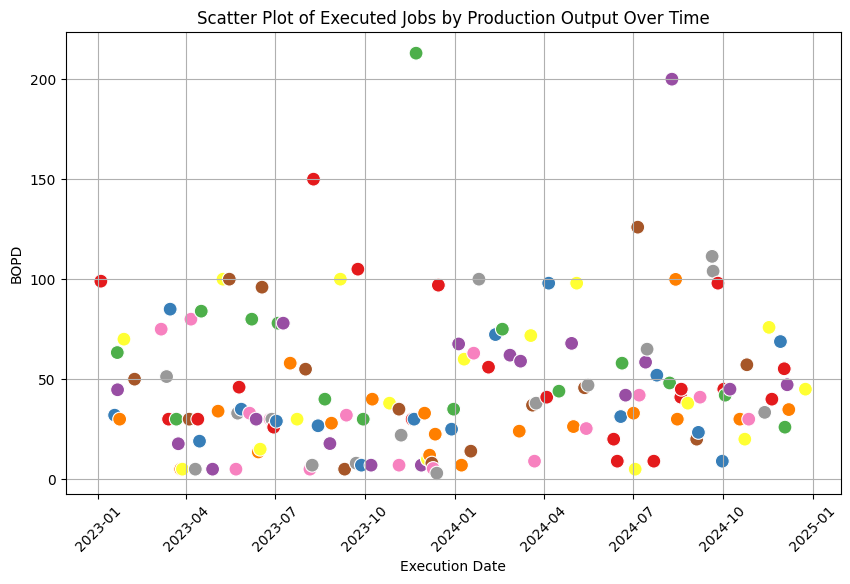

In [25]:
df['START_DATETIME_JOB'] = pd.to_datetime(df['START_DATETIME_JOB'])
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='START_DATETIME_JOB', y='BOPD', hue='WELL_ALIAS', palette='Set1', s=100)
plt.title('Scatter Plot of Executed Jobs by Production Output Over Time')
plt.xlabel('Execution Date')
plt.ylabel('BOPD')
plt.xticks(rotation=45)
plt.legend().remove()
plt.grid(True)
plt.show()

Q1 (25%): 24.25, Q2 (Median): 36.00, Q3 (75%): 61.50


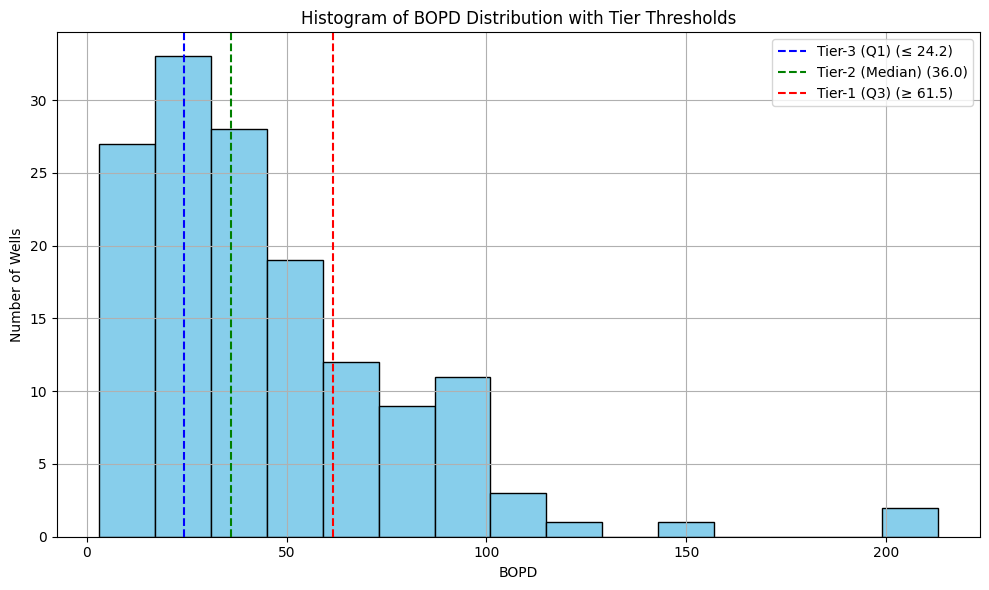

In [27]:
df_valid = df[(df['BOPD'] > 0) &
              df['SURFACE_LATITUDE'].notnull() &
              df['SURFACE_LONGITUDE'].notnull()].copy()

df_valid = df_valid.reset_index(drop=True)

# Count quantile
q1 = df_valid['BOPD'].quantile(0.25)
q2 = df_valid['BOPD'].quantile(0.50)
q3 = df_valid['BOPD'].quantile(0.75)

print(f"Q1 (25%): {q1:.2f}, Q2 (Median): {q2:.2f}, Q3 (75%): {q3:.2f}")

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(df_valid['BOPD'], bins=15, color='skyblue', edgecolor='black')

plt.axvline(q1, color='blue', linestyle='--', label=f'Tier-3 (Q1) (≤ {q1:.1f})')
plt.axvline(q2, color='green', linestyle='--', label=f'Tier-2 (Median) ({q2:.1f})')
plt.axvline(q3, color='red', linestyle='--', label=f'Tier-1 (Q3) (≥ {q3:.1f})')

plt.title("Histogram of BOPD Distribution with Tier Thresholds")
plt.xlabel("BOPD")
plt.ylabel("Number of Wells")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# MODELING - GENETIC ALGORITHM - GA-1 APPROACH

In [28]:
def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0  # Radius of the Earth (km)
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    delta_phi = np.radians(lat2 - lat1)
    delta_lambda = np.radians(lon2 - lon1)

    a = np.sin(delta_phi/2.0)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda/2.0)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c  # distance (km)

In [29]:
def create_distance_matrix(locations):
    n = len(locations)
    matrix = np.zeros((n, n))
    for i in range(n):
        lat1, lon1 = locations[i]
        for j in range(n):
            if i != j:
                lat2, lon2 = locations[j]
                matrix[i][j] = haversine(lat1, lon1, lat2, lon2)
    return matrix  # dalam km

# Drop rows containing missing or incomplete data
df_clean = df.dropna(subset=['SURFACE_LATITUDE', 'SURFACE_LONGITUDE', 'WELL_ALIAS'])

locations = list(zip(df_clean['SURFACE_LATITUDE'], df_clean['SURFACE_LONGITUDE']))
well_ids = df_clean['WELL_ALIAS'].values
distance_matrix = create_distance_matrix(locations)
df_matrix = pd.DataFrame(distance_matrix, index=well_ids,
                         columns=well_ids)
print(df_matrix.round(2).iloc[:6, :6])

           WELL-1670  WELL-804  WELL-808  WELL-833  WELL-825  WELL-1750
WELL-1670       0.00      1.44      1.45     16.47      2.56       9.79
WELL-804        1.44      0.00      0.02     15.25      1.13      11.23
WELL-808        1.45      0.02      0.00     15.26      1.13      11.24
WELL-833       16.47     15.25     15.26      0.00     14.22      25.36
WELL-825        2.56      1.13      1.13     14.22      0.00      12.35
WELL-1750       9.79     11.23     11.24     25.36     12.35       0.00


In [30]:
# GA fitness/objective function
def calculate_objective(route, matrix, bopd_list, duration_days):
    total_score = 0
    current_time = 0
    for i in range(len(route)):
        well_idx = route[i]
        if i == 0:
            # No travel time needed for the first well
            travel_time = 0
        else:
            # Calculate travel time based on distance
            travel_time = matrix[route[i - 1]][well_idx] / 20 # Assume the average rig unit speed is 20 km/h

        job_time = duration_days[well_idx]
        if job_time < 0:
            job_time = 0
        total_time = travel_time + job_time
        production = bopd_list[well_idx]
        current_time += total_time
        score = total_time / production if production > 0 else float('inf')
        total_score += score
    return total_score

In [32]:
def create_route(n):
    route = list(range(1, n))           # Create a list of wells excluding index 0
    random.shuffle(route)               # Randomize the remaining wells
    return [0] + route                  # Make sure index 0 is fixed as the initial well for rig execution

#Testing
n = 10
route = create_route(n)
print(route)
print("Does it start from 0?", route[0] == 0)
print("Are all well entries unique?", len(set(route)) == n)

[0, 4, 9, 1, 8, 6, 2, 5, 3, 7]
Does it start from 0? True
Are all well entries unique? True


In [34]:
def crossover(p1, p2):
    size = len(p1)
    start, end = sorted(random.sample(range(1, size), 2))  # start from index-1, not index-0
    child = [-1] * size
    child[start:end] = p1[start:end]
    fill = [item for item in p2 if item not in child and item != 0]
    pointer = 0
    for i in range(1, size):  # start from 1
        if child[i] == -1:
            child[i] = fill[pointer]
            pointer += 1
    child[0] = 0  # Ensure index 0 stays at the front
    return child

In [36]:
def mutate(route, rate=0.02):
    for i in range(1, len(route)):
        if random.random() < rate:
            j = random.randint(1, len(route) - 1)
            route[i], route[j] = route[j], route[i]
    return route

In [37]:
# GA main function
def genetic_algorithm(matrix, bopd_list, duration_days, generations=500, pop_size=400):
    best_scores = []
    population = [create_route(len(matrix)) for _ in range(pop_size)]
    for gen in range(generations):
        # Order the population according to fitness values
        population.sort(key=lambda x: calculate_objective(x, matrix, bopd_list, duration_days))
        best_scores.append(calculate_objective(population[0], matrix, bopd_list, duration_days))
        # Select the best 5 individuals
        next_gen = population[:5]
        while len(next_gen) < pop_size:
            parents = random.sample(population[:20], 2)  # Select parent
            child = mutate(crossover(parents[0], parents[1]))  # Crossover and mutation
            next_gen.append(child)
        population = next_gen
    best_route = min(population, key=lambda x: calculate_objective(x, matrix, bopd_list, duration_days))
    best_score = calculate_objective(best_route, matrix, bopd_list, duration_days)
    return best_route, best_score, best_scores

In [38]:
df_valid = df[(df['BOPD'] > 0) & df['SURFACE_LATITUDE'].notnull() & df['SURFACE_LONGITUDE'].notnull()].copy()

# Calculate the work duration in days for GA calculation
df_valid['duration_days'] = (
    (df_valid['END_DATETIME_JOB'] - df_valid['START_DATETIME_JOB'] - pd.to_timedelta(df_valid['MOVING_TIME'], unit='D'))
    .dt.total_seconds() / 86400
).fillna(2)

bopd_list = df_valid['BOPD'].tolist()  # Production well
duration_days = df_valid['duration_days'].tolist()  # Duration job
locations = list(zip(df_valid['SURFACE_LATITUDE'], df_valid['SURFACE_LONGITUDE']))
duration_days = df_valid['duration_days'].tolist()

In [40]:
distance_matrix = create_distance_matrix(locations)

# GA
best_route, best_score, best_scores = genetic_algorithm(distance_matrix, bopd_list, duration_days)

print(f'Best route score: {best_score:.2f}')
print("Best Route (Index):", best_route)
print("Well Order:", df_valid.iloc[best_route]['WELL_ALIAS'].tolist())
total_bopd = sum([bopd_list[i] for i in best_route])
print(f'Total BOPD from best route: {total_bopd:.1f}')

Best route score: 20.25
Best Route (Index): [0, 9, 44, 43, 14, 90, 42, 139, 18, 39, 111, 143, 79, 2, 62, 40, 98, 140, 63, 103, 76, 60, 15, 49, 122, 1, 135, 52, 138, 71, 22, 119, 68, 82, 67, 84, 83, 133, 5, 53, 13, 130, 10, 120, 134, 131, 70, 29, 72, 7, 21, 132, 126, 48, 109, 34, 41, 110, 142, 20, 4, 136, 104, 8, 50, 117, 17, 46, 47, 115, 127, 97, 105, 124, 116, 26, 80, 113, 36, 30, 137, 125, 141, 37, 45, 145, 101, 75, 56, 85, 73, 108, 74, 78, 89, 3, 64, 65, 100, 106, 16, 35, 128, 129, 19, 58, 55, 23, 114, 28, 123, 81, 12, 95, 31, 66, 6, 102, 38, 107, 59, 24, 121, 99, 33, 57, 77, 11, 92, 25, 51, 94, 54, 91, 144, 61, 112, 96, 27, 32, 93, 118, 69, 86, 87, 88]
Well Order: ['WELL-1670', 'WELL-778', 'WELL-784', 'WELL-1671', 'WELL-879', 'WELL-1720', 'WELL-932', 'WELL-982', 'WELL-732', 'WELL-693', 'WELL-1449', 'WELL-1464', 'WELL-976', 'WELL-808', 'WELL-597', 'WELL-1360', 'WELL-1041', 'WELL-1572', 'WELL-1363', 'WELL-1646', 'WELL-1692', 'WELL-1506', 'WELL-621', 'WELL-789', 'WELL-807', 'WELL-804'

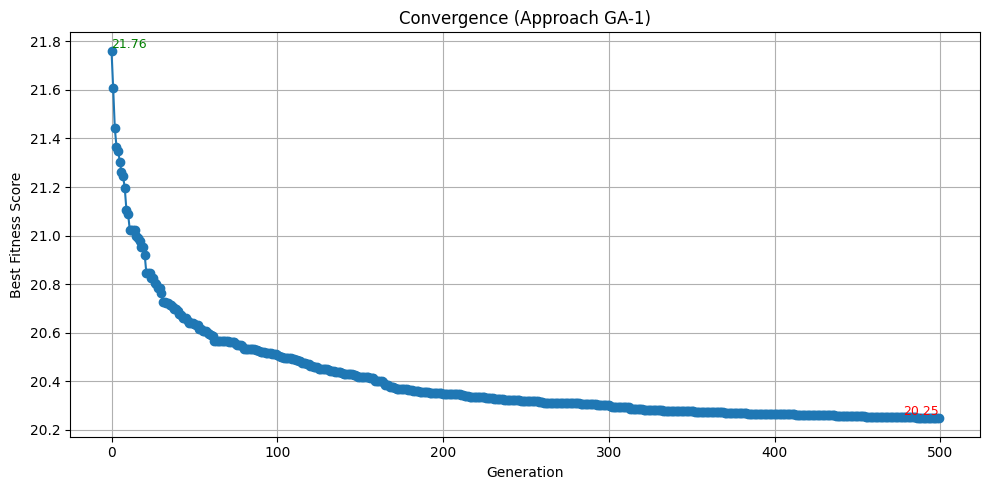

In [42]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(best_scores, marker='o')
plt.title('Convergence (Approach GA-1)')
plt.xlabel('Generation')
plt.ylabel('Best Fitness Score')
plt.grid(True)

plt.text(0, best_scores[0], f'{best_scores[0]:.2f}',
         ha='left', va='bottom', fontsize=9, color='green')

plt.text(len(best_scores)-1, best_scores[-1], f'{best_scores[-1]:.2f}',
         ha='right', va='bottom', fontsize=9, color='red')

plt.tight_layout()
plt.show()


In [43]:
# GA route evaluation

t0 = pd.to_datetime(df_valid['START_DATETIME_JOB'].min())
df_ga = df_valid.iloc[best_route].reset_index(drop=True)
speed_km_per_day = 20  # Assumed rig speed

travel_times = [0]  # No travel time needed for the first well
for i in range(1, len(best_route)):
    prev = best_route[i - 1]
    curr = best_route[i]
    distance = distance_matrix[prev][curr]
    travel_time = distance / speed_km_per_day
    travel_times.append(travel_time)

df_ga['travel_time'] = travel_times
df_ga['total_time'] = df_ga['duration_days'] + df_ga['travel_time']
df_ga['cum_time'] = df_ga['total_time'].cumsum()

df_ga['executed_date'] = t0 + pd.to_timedelta(df_ga['cum_time'], unit='D')
df_ga['executed_month'] = df_ga['executed_date'].dt.to_period('M')
df_ga['executed_year'] = df_ga['executed_date'].dt.year

print("Sequence of routes produced by the Genetic Algorithm (GA):")
print(" → ".join(df_ga['WELL_ALIAS'].tolist()))
print("Travel time max:", df_ga['travel_time'].max(), "days")
print("Total execution time:", df_ga['cum_time'].iloc[-1], "days")


Sequence of routes produced by the Genetic Algorithm (GA):
WELL-1670 → WELL-778 → WELL-784 → WELL-1671 → WELL-879 → WELL-1720 → WELL-932 → WELL-982 → WELL-732 → WELL-693 → WELL-1449 → WELL-1464 → WELL-976 → WELL-808 → WELL-597 → WELL-1360 → WELL-1041 → WELL-1572 → WELL-1363 → WELL-1646 → WELL-1692 → WELL-1506 → WELL-621 → WELL-789 → WELL-807 → WELL-804 → WELL-826 → WELL-820 → WELL-830 → WELL-862 → WELL-1607 → WELL-1607 → WELL-533 → WELL-1498 → WELL-1317 → WELL-1526 → WELL-1173 → WELL-1566 → WELL-1750 → WELL-1260 → WELL-1562 → WELL-1712 → WELL-1448 → WELL-1366 → WELL-830 → WELL-1495 → WELL-1607 → WELL-657 → WELL-1623 → WELL-657 → WELL-1127 → WELL-811 → WELL-1667 → WELL-1668 → WELL-1732 → WELL-1698 → WELL-1307 → WELL-484 → WELL-887 → WELL-1263 → WELL-825 → WELL-1066 → WELL-763 → WELL-774 → WELL-769 → WELL-1738 → WELL-861 → WELL-1666 → WELL-1697 → WELL-1549 → WELL-1742 → WELL-596 → WELL-1250 → WELL-1250 → WELL-1324 → WELL-1361 → WELL-768 → WELL-1667 → WELL-785 → WELL-1677 → WELL-1673 → WE

In [44]:
df_ga

,WELL_ALIAS,SURFACE_LATITUDE,SURFACE_LONGITUDE,BOPD,START_DATETIME_JOB,END_DATETIME_JOB,MOVING_TIME,Month,Month_Label,Month_Sort,Year,duration_days,travel_time,total_time,cum_time,executed_date,executed_month,executed_year
0,WELL-1670,2.510216,116.968560,99.0,2023-01-03 19:00:00,2023-01-15 22:00:00,0.75,2023-01,Jan 2023,2023-01,2023,11.375000,0.000000,11.375000,11.375000,2023-01-15 04:00:00.000000000,2023-01,2023
1,WELL-778,2.523126,116.976987,30.0,2023-03-14 01:30:00,2023-03-15 16:00:00,0.40,2023-03,Mar 2023,2023-03,2023,1.204167,0.085692,1.289859,12.664859,2023-01-16 10:57:23.820642636,2023-01,2023
2,WELL-784,2.523097,116.977042,5.0,2023-08-05 17:30:00,2023-08-08 00:00:00,1.00,2023-08,Aug 2023,2023-08,2023,1.270833,0.000349,1.271182,13.936041,2023-01-17 17:27:53.949558067,2023-01,2023
3,WELL-1671,2.526059,116.977287,55.0,2023-08-01 05:00:00,2023-08-05 17:30:00,1.32,2023-08,Aug 2023,2023-08,2023,3.200833,0.016528,3.217361,17.153402,2023-01-20 22:40:53.951426397,2023-01,2023
4,WELL-879,2.529418,116.983060,5.0,2023-03-28 05:00:00,2023-03-30 07:00:00,0.51,2023-03,Mar 2023,2023-03,2023,1.573333,0.037105,1.610439,18.763841,2023-01-22 13:19:55.864541389,2023-01,2023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141,WELL-1724,2.536667,116.960466,99.9,2024-08-13 21:30:00,2024-08-15 14:30:00,0.61,2024-08,Aug 2024,2024-08,2024,1.098333,0.432701,1.531034,585.196989,2024-08-10 23:43:39.827126539,2024-08,2024
142,WELL-1058,2.532639,116.962307,10.0,2023-12-03 22:30:00,2023-12-06 03:30:00,0.51,2023-12,Dec 2023,2023-12,2023,1.698333,0.024619,1.722952,586.919941,2024-08-12 17:04:42.877816098,2024-08,2024
143,WELL-1008,2.465295,116.987553,75.0,2024-02-18 14:30:00,2024-02-26 09:30:00,1.26,2024-02,Feb 2024,2024-02,2024,6.531667,0.399815,6.931482,593.851423,2024-08-19 15:26:02.920043909,2024-08,2024
144,WELL-1426,2.464493,117.095655,62.0,2024-02-26 09:30:00,2024-03-06 20:30:00,2.09,2024-02,Feb 2024,2024-02,2024,7.368333,0.600480,7.968814,601.820236,2024-08-27 14:41:08.408656060,2024-08,2024


In [45]:
df['Month_Label'] = df['START_DATETIME_JOB'].dt.strftime('%B %Y')
df['Month_Sort'] = df['START_DATETIME_JOB'].dt.to_period('M').astype(str)

# Baseline
baseline_jobs = df.groupby(['Month_Sort', 'Month_Label']).size().reset_index(name='Baseline Jobs')
baseline_prod = df.groupby(['Month_Sort', 'Month_Label'])['BOPD'].sum().reset_index(name='Baseline Production')

# GA
df_ga['Month_Label'] = df_ga['executed_date'].dt.strftime('%B %Y')
df_ga['Month_Sort'] = df_ga['executed_date'].dt.to_period('M').astype(str)
ga_jobs = df_ga.groupby(['Month_Sort', 'Month_Label']).size().reset_index(name='GA Jobs')
ga_prod = df_ga.groupby(['Month_Sort', 'Month_Label'])['BOPD'].sum().reset_index(name='GA Production')

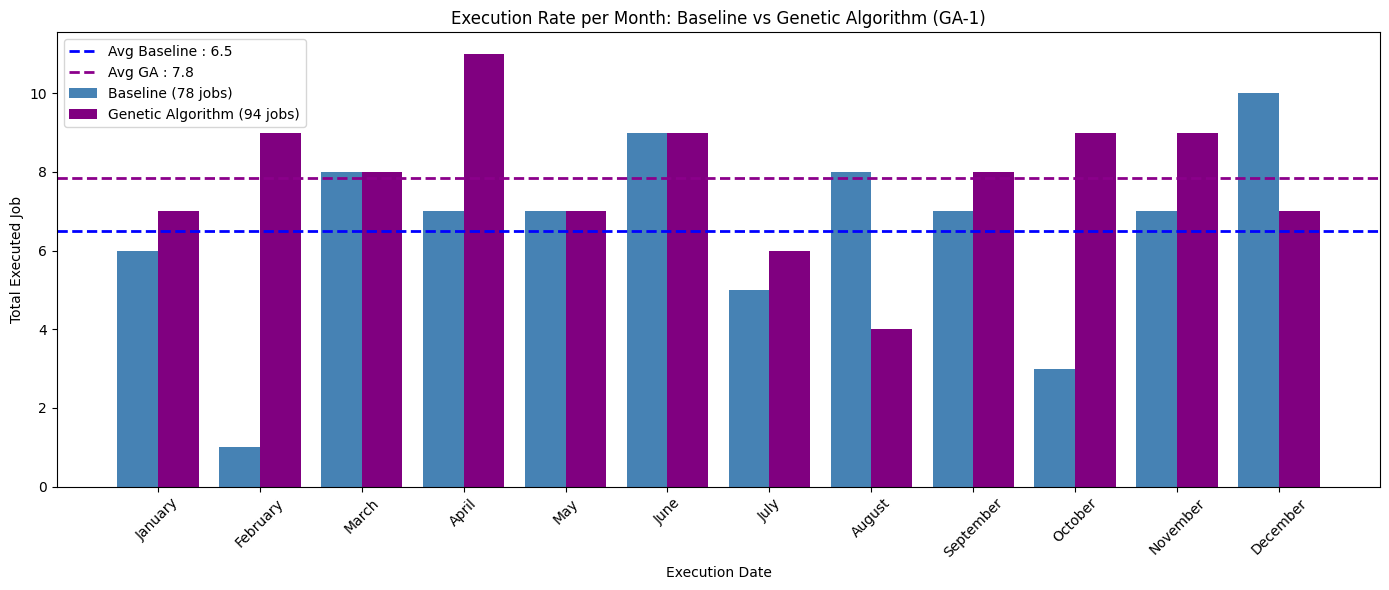

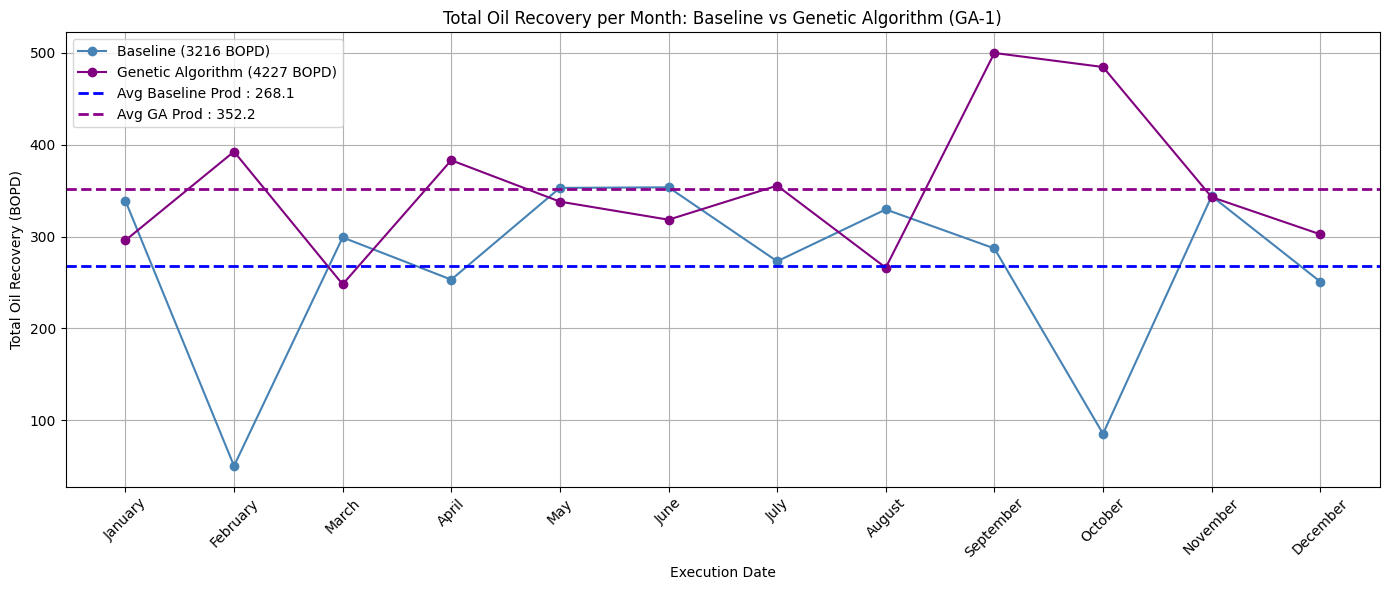

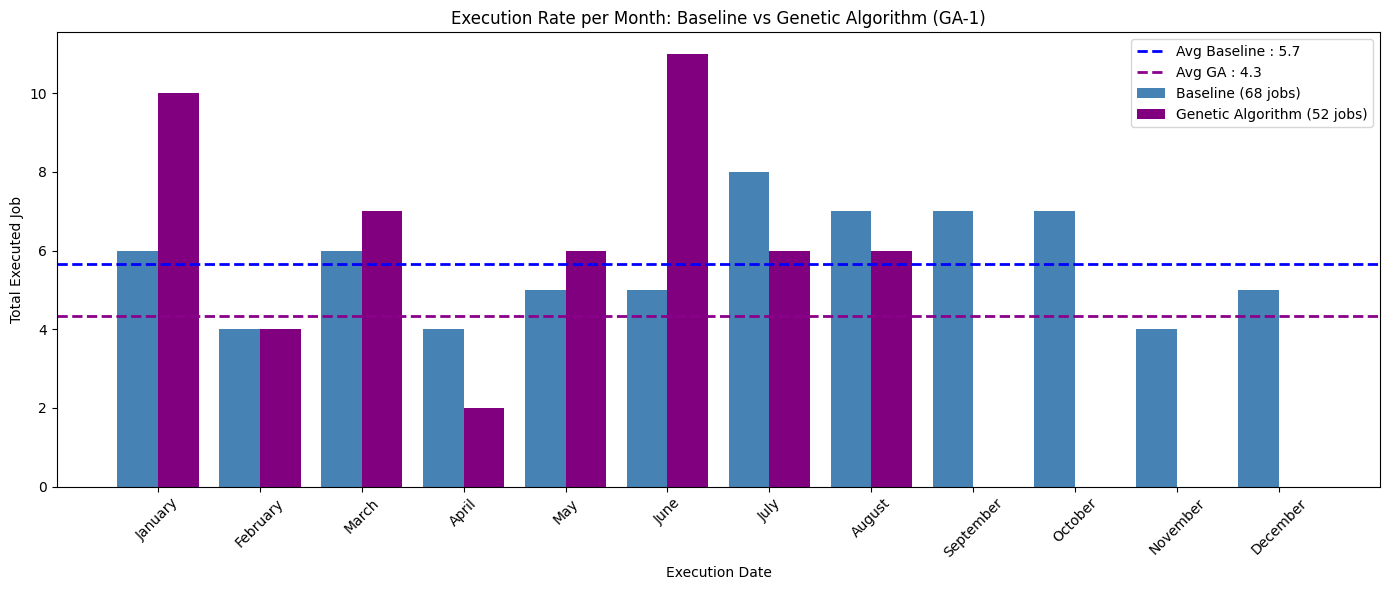

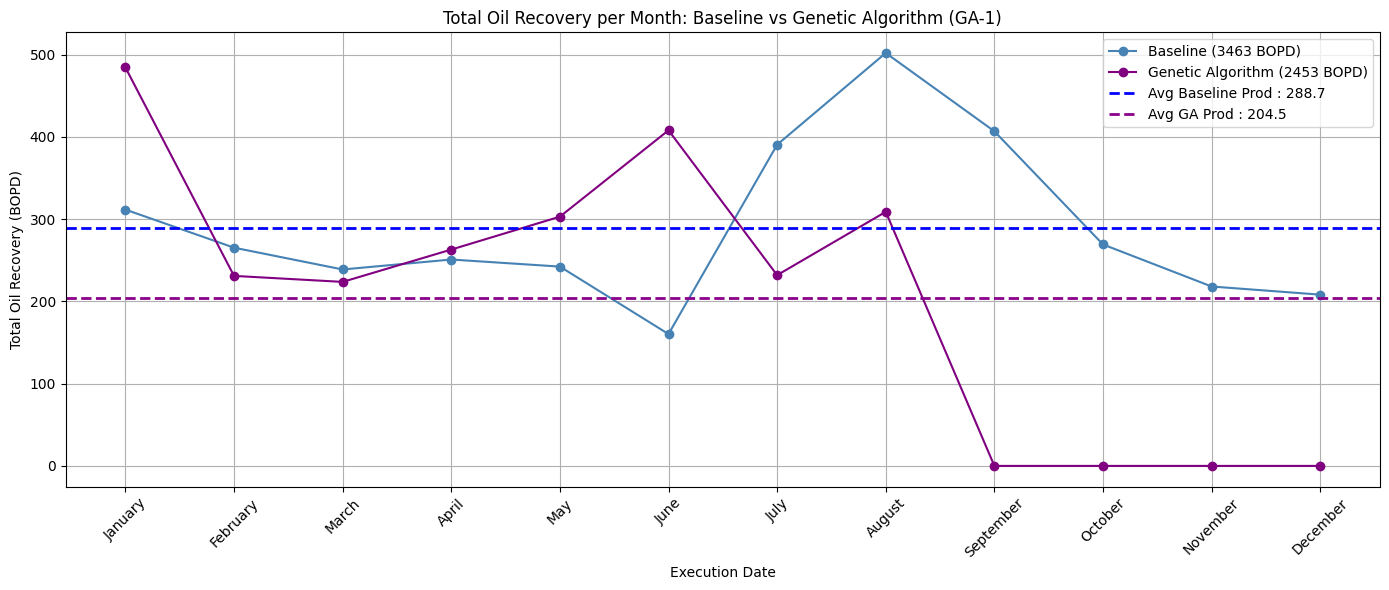

In [46]:
years = sorted(set(df['START_DATETIME_JOB'].dt.year.unique()) | set(df_ga['executed_date'].dt.year.unique()))

for year in years:

    baseline = df[df['START_DATETIME_JOB'].dt.year == year].copy()
    ga_year = df_ga[df_ga['executed_date'].dt.year == year].copy()

    baseline['Month_Label'] = baseline['START_DATETIME_JOB'].dt.strftime('%B')
    baseline['Month_Sort'] = baseline['START_DATETIME_JOB'].dt.to_period('M').astype(str)
    ga_year['Month_Label'] = ga_year['executed_date'].dt.strftime('%B')
    ga_year['Month_Sort'] = ga_year['executed_date'].dt.to_period('M').astype(str)

    # --- JOB EXECUTION COMPARISON ---
    baseline_jobs = baseline.groupby(['Month_Sort', 'Month_Label']).size().reset_index(name='Baseline Jobs')
    ga_jobs = ga_year.groupby(['Month_Sort', 'Month_Label']).size().reset_index(name='GA Jobs')
    jobs_compare = pd.merge(baseline_jobs, ga_jobs, on=['Month_Sort', 'Month_Label'], how='outer').fillna(0).sort_values('Month_Sort')

    avg_jobs_baseline = jobs_compare['Baseline Jobs'].mean()
    avg_jobs_ga = jobs_compare['GA Jobs'].mean()

    # Plot bar chart
    bar_width = 0.4
    x = np.arange(len(jobs_compare))
    plt.figure(figsize=(14,6))
    total_jobs_baseline = jobs_compare['Baseline Jobs'].sum()
    total_jobs_ga = jobs_compare['GA Jobs'].sum()

    plt.bar(x - bar_width/2, jobs_compare['Baseline Jobs'], width=bar_width, color='steelblue',
            label=f'Baseline ({int(total_jobs_baseline)} jobs)')
    plt.bar(x + bar_width/2, jobs_compare['GA Jobs'], width=bar_width, color='purple',
            label=f'Genetic Algorithm ({int(total_jobs_ga)} jobs)')


    plt.axhline(y=avg_jobs_baseline, color='blue', linestyle='--', linewidth=2, label=f'Avg Baseline : {avg_jobs_baseline:.1f}')
    plt.axhline(y=avg_jobs_ga, color='darkmagenta', linestyle='--', linewidth=2, label=f'Avg GA : {avg_jobs_ga:.1f}')

    plt.title(f'Execution Rate per Month: Baseline vs Genetic Algorithm (GA-1)')
    plt.xlabel('Execution Date')
    plt.ylabel('Total Executed Job')
    plt.xticks(x, jobs_compare['Month_Label'], rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # --- PRODUCTION COMPARISON ---
    baseline_prod = baseline.groupby(['Month_Sort', 'Month_Label'])['BOPD'].sum().reset_index(name='Baseline Production')
    ga_prod = ga_year.groupby(['Month_Sort', 'Month_Label'])['BOPD'].sum().reset_index(name='GA Production')
    prod_compare = pd.merge(baseline_prod, ga_prod, on=['Month_Sort', 'Month_Label'], how='outer').fillna(0).sort_values('Month_Sort')

    avg_prod_baseline = prod_compare['Baseline Production'].mean()
    avg_prod_ga = prod_compare['GA Production'].mean()

    # Plot line chart
    plt.figure(figsize=(14,6))
    total_prod_baseline = prod_compare['Baseline Production'].sum()
    total_prod_ga = prod_compare['GA Production'].sum()

    plt.plot(prod_compare['Month_Label'], prod_compare['Baseline Production'], marker='o', color='steelblue',
            label=f'Baseline ({int(total_prod_baseline)} BOPD)')
    plt.plot(prod_compare['Month_Label'], prod_compare['GA Production'], marker='o', color='purple',
            label=f'Genetic Algorithm ({int(total_prod_ga)} BOPD)')

    plt.axhline(y=avg_prod_baseline, color='blue', linestyle='--', linewidth=2, label=f'Avg Baseline Prod : {avg_prod_baseline:.1f}')
    plt.axhline(y=avg_prod_ga, color='darkmagenta', linestyle='--', linewidth=2, label=f'Avg GA Prod : {avg_prod_ga:.1f}')

    plt.title(f'Total Oil Recovery per Month: Baseline vs Genetic Algorithm (GA-1)')
    plt.xlabel('Execution Date')
    plt.ylabel('Total Oil Recovery (BOPD)')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [50]:
def haversine_km(lat1, lon1, lat2, lon2):
    from math import radians, sin, cos, sqrt, atan2
    R = 6371.0
    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)
    lat1 = radians(lat1)
    lat2 = radians(lat2)
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c

def calculate_route_stats(df):
    total_distance = 0
    for i in range(1, len(df)):
        lat1, lon1 = df.iloc[i-1]['SURFACE_LATITUDE'], df.iloc[i-1]['SURFACE_LONGITUDE']
        lat2, lon2 = df.iloc[i]['SURFACE_LATITUDE'], df.iloc[i]['SURFACE_LONGITUDE']
        total_distance += haversine_km(lat1, lon1, lat2, lon2)
    return {'total_distance': total_distance}

# Compute distance reduction specifically for the year 2023 (baseline year)
df_valid_2023 = df_valid[df_valid['START_DATETIME_JOB'].dt.year == 2023]
df_ga_2023 = df_ga[df_ga['executed_date'].dt.year == 2023]

dist_base = calculate_route_stats(df_valid_2023)['total_distance']
dist_ga = calculate_route_stats(df_ga_2023)['total_distance']
distance_reduction = (dist_base - dist_ga) / dist_base * 100


In [51]:
import matplotlib.pyplot as plt
import numpy as np
from adjustText import adjust_text

def plot_route(df_sorted, title, cmap='viridis', distance_reduction=None):
    stats = calculate_route_stats(df_sorted)
    plt.figure(figsize=(16, 10))

    for i in range(1, len(df_sorted)):
        plt.plot(
            [df_sorted.iloc[i-1]['SURFACE_LONGITUDE'], df_sorted.iloc[i]['SURFACE_LONGITUDE']],
            [df_sorted.iloc[i-1]['SURFACE_LATITUDE'], df_sorted.iloc[i]['SURFACE_LATITUDE']],
            color=plt.get_cmap(cmap)(i / len(df_sorted)), linewidth=3)

    plt.scatter(df_sorted['SURFACE_LONGITUDE'], df_sorted['SURFACE_LATITUDE'],
                c=np.arange(len(df_sorted)), cmap=cmap, s=100, edgecolor='black', zorder=5)

    texts = []
    for i, row in df_sorted.iterrows():
        texts.append(
            plt.text(row['SURFACE_LONGITUDE'], row['SURFACE_LATITUDE'], row['WELL_ALIAS'],
                     fontsize=8, alpha=0.7, zorder=6)
        )
    adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))

    stats_text = (
        f"{title} Statistics:\n"
        f"- Total Distance: {stats['total_distance']:.2f} KM\n"
        f"- Number of Points: {len(df_sorted)}"
    )
    if distance_reduction is not None:
        stats_text += f"\n- Distance Reduction: {distance_reduction:.2f}%"

    plt.gca().add_patch(plt.Rectangle((0.05, 0.75), 0.4, 0.2,
                                      facecolor='white', alpha=0.8, transform=plt.gca().transAxes))
    plt.text(0.07, 0.93, stats_text, transform=plt.gca().transAxes, ha='left', va='top',
             fontsize=10, bbox=dict(facecolor='none', edgecolor='none'))

    plt.title(title, pad=20, fontsize=14)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.grid(True, alpha=0.3)

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=1, vmax=len(df_sorted)))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=plt.gca(), orientation='vertical', fraction=0.02, pad=0.04)
    cbar.set_label('Route Sequence', rotation=270, labelpad=15)

    plt.tight_layout()
    plt.show()

7 [0.98217275 0.32632096]
29 [0.96230861 0.36765654]
22 [0.46561042 0.23901161]
70 [-0.66207909  0.98676729]
4 [-0.35185809  0.67133952]
73 [-0.67735771  0.7434911 ]


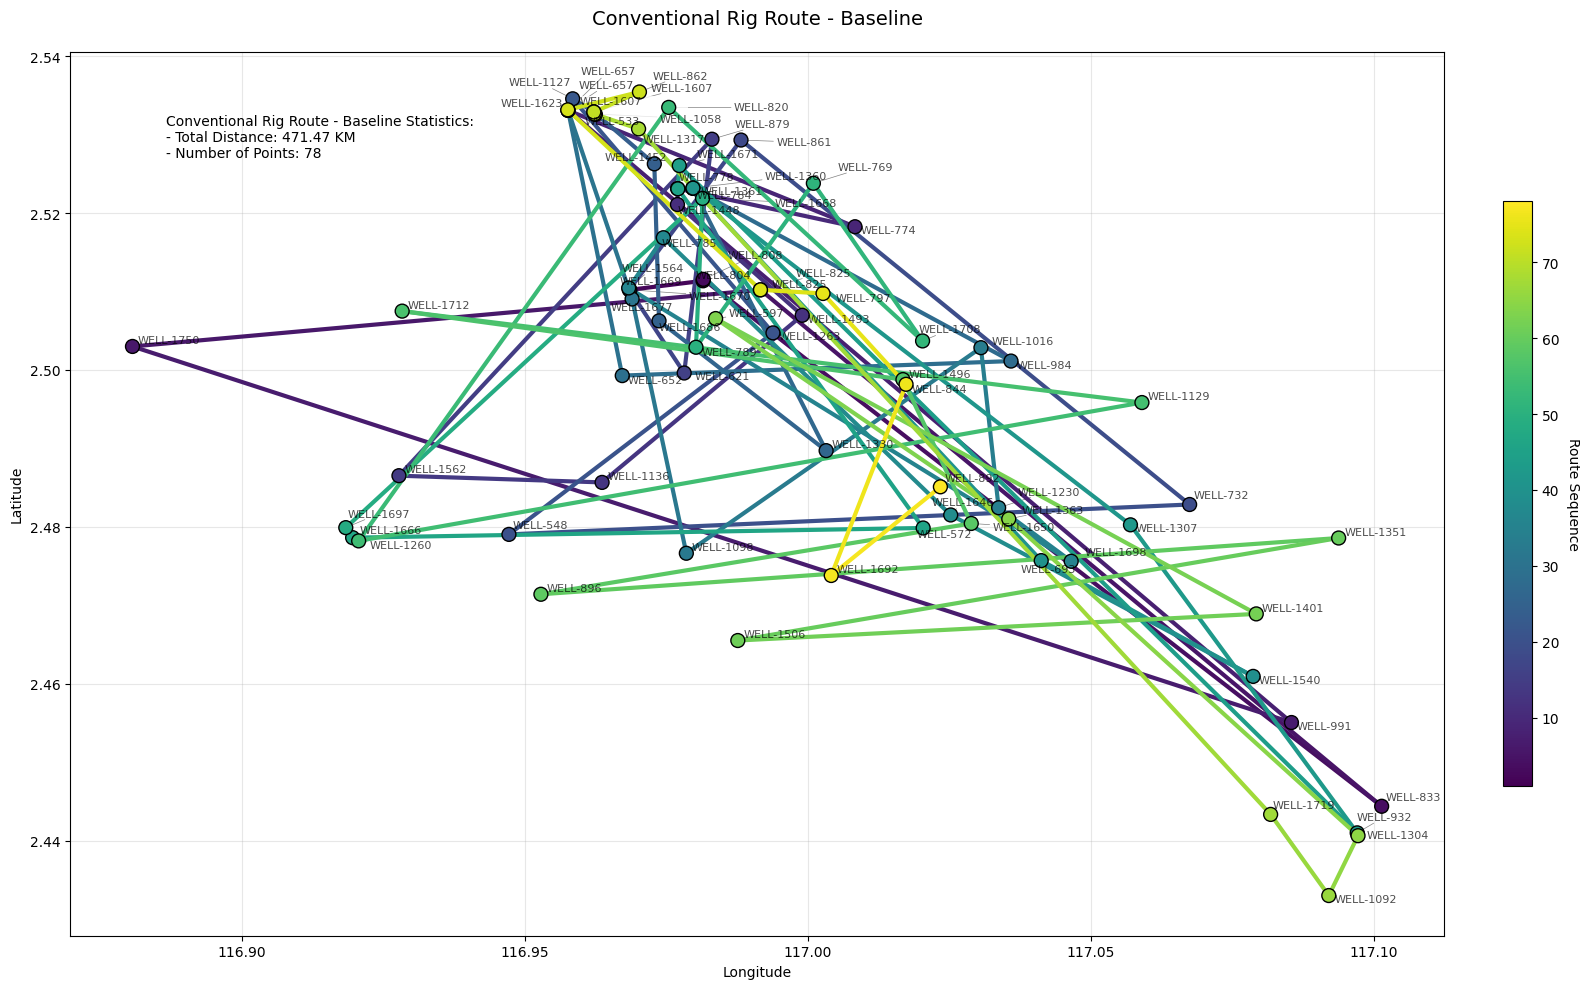

47 [-0.05146222  0.2919973 ]
49 [-0.2683113  -0.51814376]
30 [ 0.13227953 -0.9640385 ]
31 [ 0.27740386 -0.22762767]
46 [ 0.85949672 -0.90180727]
28 [-0.70531567  0.07130942]
44 [-0.24360359 -0.99121495]
72 [0.09674355 0.80509403]
73 [-0.92493511 -0.13821344]
52 [-0.66584701  0.77510218]
77 [ 0.87035931 -0.04219036]
60 [ 0.17247089 -0.93073828]
90 [ 0.20729276 -0.80583848]
19 [-0.19265054  0.96295988]
82 [-0.98316816  0.96009173]
83 [-0.04839806 -0.49758562]


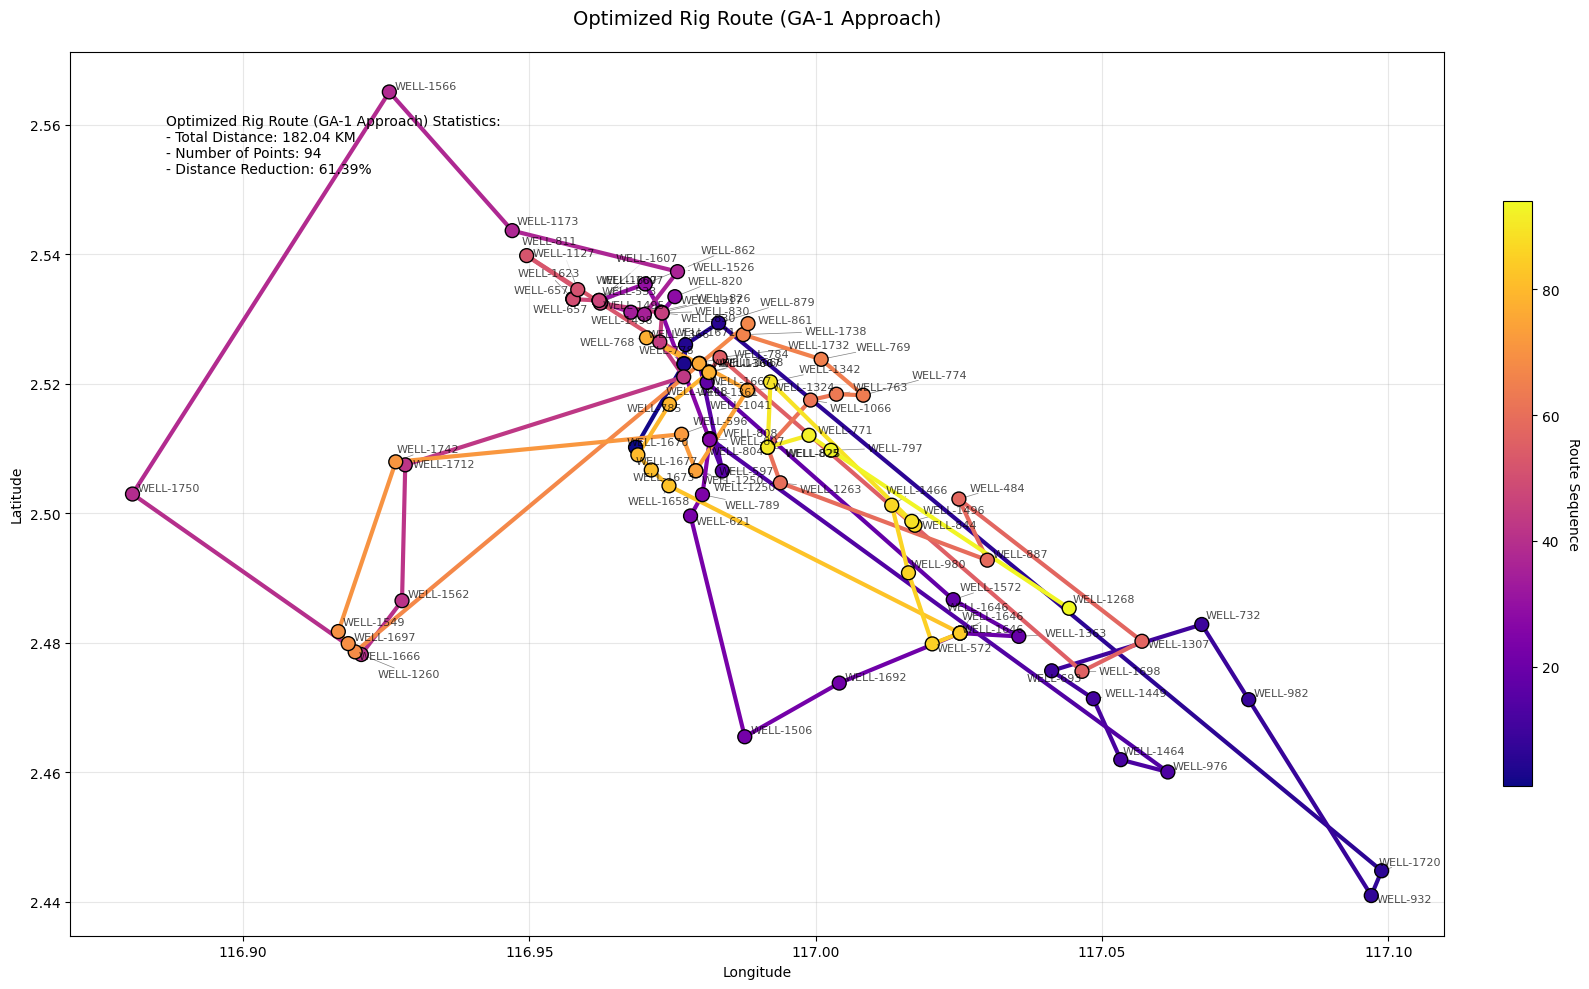

In [52]:
plot_route(
    df_valid_2023.sort_values(by='START_DATETIME_JOB').reset_index(drop=True),
    title='Conventional Rig Route - Baseline',
    cmap='viridis'
)

plot_route(
    df_ga_2023.reset_index(drop=True),
    title='Optimized Rig Route (GA-1 Approach)',
    cmap='plasma',
    distance_reduction=distance_reduction
)


In [54]:
import folium
from folium.plugins import MarkerCluster
from IPython.display import display
import pandas as pd
import numpy as np

def interpolate_points(p1, p2, n=3):
    lat1, lon1 = p1
    lat2, lon2 = p2
    return [(lat1 + (lat2 - lat1) * i / n, lon1 + (lon2 - lon1) * i / n) for i in range(1, n)]

lat_center = df_ga['SURFACE_LATITUDE'].mean()
lon_center = df_ga['SURFACE_LONGITUDE'].mean()

m = folium.Map(location=[lat_center, lon_center], zoom_start=13, tiles='OpenStreetMap')

route_points = []
for i in range(1, len(df_ga)):
    p1 = (df_ga.iloc[i-1]['SURFACE_LATITUDE'], df_ga.iloc[i-1]['SURFACE_LONGITUDE'])
    p2 = (df_ga.iloc[i]['SURFACE_LATITUDE'], df_ga.iloc[i]['SURFACE_LONGITUDE'])
    route_points.extend([p1] + interpolate_points(p1, p2, n=5))  # n=5 titik per segmen
route_points.append(p2)

# Plot the route path on the map
folium.PolyLine(route_points, color='blue', weight=4, opacity=0.7).add_to(m)

marker_cluster = MarkerCluster().add_to(m)
for i, row in df_ga.iterrows():
    popup = folium.Popup(f"{i+1}. {row['WELL_ALIAS']}<br>BOPD: {row['BOPD']}", max_width=250)
    folium.CircleMarker(
        location=(row['SURFACE_LATITUDE'], row['SURFACE_LONGITUDE']),
        radius=5,
        color='red',
        fill=True,
        fill_opacity=0.8,
        popup=popup
    ).add_to(marker_cluster)

# Show in Google Colab
display(m)


In [57]:
# Eksport excel
df_result_ga = df_valid.iloc[best_route].copy().reset_index(drop=True)
df_result_ga['Squence_Execution'] = range(1, len(df_result_ga) + 1)
df_result_ga['Executed_Date'] = t0 + pd.to_timedelta(df_result_ga['duration_days'].cumsum(), unit='D')

df_result_ga_export = df_result_ga[[
    'Squence_Execution', 'Executed_Date', 'WELL_ALIAS', 'BOPD',
    'START_DATETIME_JOB', 'END_DATETIME_JOB', 'duration_days',
    'SURFACE_LATITUDE', 'SURFACE_LONGITUDE'
]]

df_result_ga_export.to_excel('Result_GA_1_non_tier.xlsx', index=False)
print("The route generated by the Genetic Algorithm has been exported to 'Result_GA_1_non_tier.xlsx'")

The route generated by the Genetic Algorithm has been exported to 'Result_GA_1_non_tier.xlsx'


In [58]:
df_result_ga_export

,Squence_Execution,Executed_Date,WELL_ALIAS,BOPD,START_DATETIME_JOB,END_DATETIME_JOB,duration_days,SURFACE_LATITUDE,SURFACE_LONGITUDE
0,1,2023-01-15 04:00:00.000000000,WELL-1670,99.0,2023-01-03 19:00:00,2023-01-15 22:00:00,11.375000,2.510216,116.968560
1,2,2023-01-16 08:54:00.000000002,WELL-778,30.0,2023-03-14 01:30:00,2023-03-15 16:00:00,1.204167,2.523126,116.976987
2,3,2023-01-17 15:24:00.000000000,WELL-784,5.0,2023-08-05 17:30:00,2023-08-08 00:00:00,1.270833,2.523097,116.977042
3,4,2023-01-20 20:13:11.999999997,WELL-1671,55.0,2023-08-01 05:00:00,2023-08-05 17:30:00,3.200833,2.526059,116.977287
4,5,2023-01-22 09:58:48.000000002,WELL-879,5.0,2023-03-28 05:00:00,2023-03-30 07:00:00,1.573333,2.529418,116.983060
...,...,...,...,...,...,...,...,...,...
141,142,2024-07-25 23:40:48.000000034,WELL-1724,99.9,2024-08-13 21:30:00,2024-08-15 14:30:00,1.098333,2.536667,116.960466
142,143,2024-07-27 16:26:24.000000040,WELL-1058,10.0,2023-12-03 22:30:00,2023-12-06 03:30:00,1.698333,2.532639,116.962307
143,144,2024-08-03 05:12:00.000000034,WELL-1008,75.0,2024-02-18 14:30:00,2024-02-26 09:30:00,6.531667,2.465295,116.987553
144,145,2024-08-10 14:02:24.000000031,WELL-1426,62.0,2024-02-26 09:30:00,2024-03-06 20:30:00,7.368333,2.464493,117.095655
